In [1]:
import numpy as np
import torch
import networkx as nx

from src.causal_recourse_gen import CausalRecourseGeneration

In [2]:
%load_ext autoreload
%autoreload 2

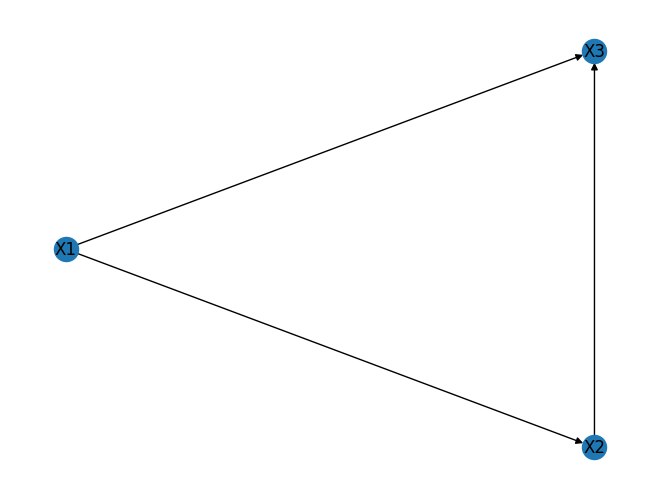

In [3]:
W_adjacency = np.array([[0, 0.3, 0.2], [0, 0, -0.4], [0, 0, 0]])
# draw graph from adjacency matrix
G = nx.from_numpy_array(W_adjacency, create_using=nx.DiGraph)
nx.draw_shell(G, with_labels=True, labels={0: "X1", 1: "X2", 2: "X3"})

In [4]:
W_classifier = np.array([0.5, 0.6, 0.7])
b_classifier = -0.5

In [5]:
X = np.array([[0.2, -0.8, -0.4], [-0.6, -0.9, -0.3]])

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [7]:
sigmoid(X @ W_classifier + b_classifier)

array([0.23866729, 0.17508627])

In [9]:
recourse_gen = CausalRecourseGeneration(
    learn_beta=False, learn_ordering=False
)
recourse_gen.add_data(
    X=torch.tensor(X),
    W_adjacency=torch.tensor(W_adjacency),
    W_classifier=torch.tensor(W_classifier),
    b_classifier=torch.tensor(b_classifier),
)
recourse_gen.set_ordering(torch.Tensor([0, 1, 2]).repeat(2, 1))
recourse_gen.set_beta(torch.Tensor([1, 1, 1]))
recourse_df = recourse_gen.gen_recourse(classifier_margin=0, max_epochs=2000)

In [10]:
recourse_df

,X1,X2,X3,a1,a2,a3,order1,order2,order3,cost,prob
0,0.953630,-0.279812,0.276429,0.753626,0.294098,0.643339,0.0,1.0,2.0,1.068342,0.500607
1,0.406837,-0.205037,0.603698,1.006840,0.392913,0.859497,0.0,1.0,2.0,1.906832,0.500746


In [11]:
# sample different betas
betas = np.random.uniform(0, 2, (2, 5,3))

In [13]:
for beta in betas:
    recourse_gen.set_beta(torch.tensor(beta, dtype=torch.float32))
    df = recourse_gen.gen_recourse(classifier_margin=0.02, max_epochs=2000)
    print(df)

ValueError: Beta must have the same number of features as X